# Genetic algorithm of protein folding

This implements the Unger and Moult, “Genetic algorithms for protein folding simulations”, J. Mol. Biol. 231, 75-81 (1993), as implemented by Prof. Richard Gonsalves. 

In [ ]:
import copy
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from operator import itemgetter

In [1]:


def new_extended_coil(dna):
    """ input:  dna sequence of 'B' (hydrophopic) and 'W' (hydrophilic) residues
        output: extended linear conformation
    """
    L = len(dna)
    assert L == dna.count('B') + dna.count('W')
    return [ [0, i] for i in range(L) ]

def E(s, dna):
    """ input:  conformation, dna sequence
        output: E = - (number of non-covalent BB nearest neighbors
    """
    L = len(s)
    n_BB = 0
    for i in range(L - 2):
        for j in range(i + 2, L):
            if dna[i] == 'B' and dna[j] == 'B':
                dx = s[i][0] - s[j][0]
                dy = s[i][1] - s[j][1]
                if abs(dx) + abs(dy) == 1:
                    n_BB += 1
    return -n_BB

def selfAvoiding(s, s_trial, i):
    for j in range(i):
        for k in range(i + 1, len(s)):
            if s_trial[j] == s[k]:
                return False
    return True

def MMC_mutation_step(s, dna, c_k):
    """ input:  conformation, temperature
        output: changed conformation, whether mutation was self-avoiding
    """
    L = len(s)
    s_trial = copy.deepcopy(s)          # for trial conformation
    i = random.randrange(1, L - 1)      # choose a random interior amino acid
    # rotation matrices for 90, 180, and 270 degrees
    rotation_matrices = [
        [
            [0, -1],
            [1,  0]
        ],
        [
            [-1, 0],
            [0, -1]
        ],
        [
            [ 0, 1],
            [-1, 0]]
        ]
    rot_mat = rotation_matrices[random.randrange(3)]
    # rotate the C-terminal (j < i) portion about amino acid i
    for j in range(i):
        dr = [ s[j][k] - s[i][k] for k in range(2) ]
        for k in range(2):
            s_trial[j][k] = s[i][k]
            for l in range(2):
                s_trial[j][k] += rot_mat[k][l] * dr[l]
    # check whether this is a valid self-avoiding conformation
    avoid = selfAvoiding( s, s_trial, i)
    if not avoid :
        return False
    # no overlaps - update conformation using Metropolis et al. algorithm
    dE = E(s_trial, dna) - E(s, dna)
    w = math.exp(- dE / c_k)
    if random.random() < w:
        for j in range(i):
            for k in range(2):
                s[j][k] = s_trial[j][k]
    return True

def simulated_annealing_run(s, dna, mmc_steps):
    """ input:  conformation s, dna, number of Metropolis Monte Carlo steps
        output: lowest energy, step found, fraction self-avoiding conformations
    """
    c_k = 2.0           # initial temperature
    alpha = 0.99        # cooling factor
    valid_confs = 0
    E_min = E(s, dna)
    step_min = 0
    for step in range(1, mmc_steps + 1):
        if MMC_mutation_step(s, dna, c_k):
            valid_confs += 1
            E_step = E(s, dna)
            if E_step < E_min:
                E_min = E_step
                step_min = step
                print(" E =", E_min, "at step", step)
        if step % 200000 == 0 and c_k > 0.15:
            c_k *= 0.99
    valid_fraction = valid_confs / float(mmc_steps)
    return E_min, step_min, valid_fraction



def simulated_ga_run(s, dna, mmc_steps, nmutants):
    """ input:  conformation s, dna, number of Metropolis Monte Carlo steps
        output: lowest energy, step found, fraction self-avoiding conformations
    """
    c_k = 2.0           # initial temperature
    alpha = 0.99        # cooling factor
    valid_confs = 0
    E_min = E(s, dna)
    step_min = 0

    # Create mutants
    mutants = [ copy.copy(s) ] * nmutants
        
 
    # Step through MC steps desired
    for step in range(1, mmc_steps + 1):
        #print 'step = ', step

        # Calculate the mutations that are valid, and lower energy than their parents
        passed = []        
        for mutant in mutants:
            #print mutant
            if MMC_mutation_step(mutant, dna, c_k):
                valid_confs += 1
                E_step = E(mutant, dna)
                if E_step < E_min:
                    passed.append( [mutant, E_step] )
                    E_min = E_step
                    step_min = step
                    print(" E =", E_min, "at step", step)


        # Sort by energy
        passed = sorted(passed, key=itemgetter(1))
        # Select two lowest energy children (require at least two children with energy less than their parents)
        if len(passed) < 2 :
            continue
        passed0 = passed[0][0]
        passed1 = passed[1][0]
        # Now "mate" the two to evolve. 
        index = random.randrange(0,len(passed0))
        child = passed0[0:index] + passed1[index:]
        if selfAvoiding(s, child, index ) : 
            # Reset the mutants to nmutant copies of the successful offspring
            mutants = [ copy.copy(child) ] * nmutants
        else :
            continue
        
        if step % 200000 == 0 and c_k > 0.15:
            c_k *= alpha
    s = mutants[ random.randrange(0,nmutants) ]
    valid_fraction = valid_confs / float(mmc_steps * nmutants)
    return E_min, step_min, valid_fraction

 Folding of a Simple Model Protein on a Square Lattice
 using Simulated Annealing and Genetic Algorithms
 R. Unger and J. Moult, J. Mol. Biol. 231, 75-81 (1993)
 ------------------------------------------------------
--------------------
Simulated annealing:
--------------------
 Initialized sequence BWBWWBBWBWWBWBBWWBWB L = 20 fully extended
 Simulated annealing with 60000 steps
 E = -1 at step 18
 E = -2 at step 41
 E = -3 at step 113
 E = -4 at step 143
 E = -5 at step 2711
 E = -7 at step 2715
 E_min = -7 at step 2715 fraction of valid configurations = 0.456
--------------------
Genetic Algorithm:
--------------------
 E = -2 at step 1
 E = -3 at step 1
 E = -4 at step 2
 E = -5 at step 7
 E = -6 at step 53
 E_min = -6 at step 53 fraction of valid configurations = 0.4614333333333333


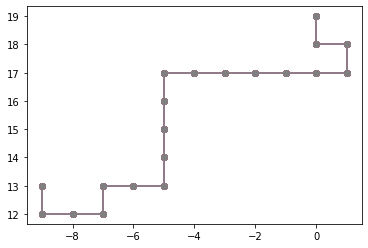

In [4]:

print(" Folding of a Simple Model Protein on a Square Lattice")
print(" using Simulated Annealing and Genetic Algorithms")
print(" R. Unger and J. Moult, J. Mol. Biol. 231, 75-81 (1993)")
print(" ------------------------------------------------------")

# sample protein with 20 amino acids
dna = "BWBWWBBWBWWBWBBWWBWB"
p20 = new_extended_coil(dna)
L = len(p20)
mmc_steps = 300 * 200

# First try simulated annealing
print ('--------------------')
print ('Simulated annealing:')
print ('--------------------')
print(" Initialized sequence", dna, "L =", L, "fully extended")
print(" Simulated annealing with", mmc_steps, "steps")
E_min, step_min, valid_confs = simulated_annealing_run(p20, dna, mmc_steps)
print(" E_min =", E_min, "at step", step_min,
    "fraction of valid configurations =", valid_confs)

print ('--------------------')
print ('Genetic Algorithm:')
print ('--------------------')
# sample protein with 20 amino acids
dna = "BWBWWBBWBWWBWBBWWBWB"
p20 = new_extended_coil(dna)
L = len(p20)
mmc_steps = 300

# Now run the GA
nmutants = 200
E_min, step_min, valid_confs = simulated_ga_run(p20, dna, mmc_steps, nmutants)
print(" E_min =", E_min, "at step", step_min,
    "fraction of valid configurations =", valid_confs)

x = []
y = []
for ip20 in p20:
    x.append( ip20[0] )
    y.append( ip20[1] )

for i in range(len(x)-2):
    plt.plot( x,y , marker='o')
    
#plt.axis([-20,20,-20,20])
plt.show()

